In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm
import os
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from keras.applications import EfficientNetB0
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
import ipywidgets as widgets
import io
from PIL import Image
from IPython.display import display,clear_output
from warnings import filterwarnings
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from tensorflow.keras.callbacks import TensorBoard
from keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, UpSampling2D, BatchNormalization

In [2]:
for dirname, _, filenames in os.walk('Seminar'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
colors_dark = ["#1F1F1F", "#313131", '#636363', '#AEAEAE', '#DADADA']
colors_red = ["#331313", "#582626", '#9E1717', '#D35151', '#E9B4B4']
colors_green = ['#01411C','#4B6F44','#4F7942','#74C365','#D0F0C0']
labels = ['glioma','notumor','meningioma','pituitary']

In [3]:
X_train = []
y_train = []
image_size = 80
for i in labels:
    folderPath = os.path.join('Training',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size, image_size))
        X_train.append(img)
        y_train.append(i)
        
for i in labels:
    folderPath = os.path.join('Testing',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size,image_size))
        X_train.append(img)
        y_train.append(i)

100%|██████████| 300/300 [00:05<00:00, 59.06it/s]


In [4]:
X_train = np.array(X_train)
y_train = np.array(y_train)
X_train, y_train = shuffle(X_train,y_train, random_state=101)
X_train,X_test,y_train,y_test = train_test_split(X_train,y_train, test_size=0.1,random_state=101)

In [5]:
# Data Augmentation
datagen = ImageDataGenerator(rotation_range=90, vertical_flip=True)

# Augment the training data and concatenate the original data with augmented data
X_train_augmented, y_train_augmented = [], []

for batch_X, batch_y in datagen.flow(X_train, y_train, batch_size=16, shuffle=False):
    X_train_augmented.append(batch_X)
    y_train_augmented.append(batch_y)
    if len(X_train_augmented) * 16 >= len(X_train):  # Stop after augmenting enough samples
        break

X_train_augmented = np.concatenate(X_train_augmented, axis=0)
y_train_augmented = np.concatenate(y_train_augmented, axis=0)

# Concatenate original and augmented data
X_train = np.concatenate((X_train, X_train_augmented), axis=0)
y_train = np.concatenate((y_train, y_train_augmented), axis=0)
y_train_new = []
for i in y_train:
    y_train_new.append(labels.index(i))
y_train = y_train_new
y_train = tf.keras.utils.to_categorical(y_train)

y_test_new = []
for i in y_test:
    y_test_new.append(labels.index(i))
y_test = y_test_new
y_test = tf.keras.utils.to_categorical(y_test)

In [8]:
from keras.models import Model
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

input_img = Input(shape=(80, 80, 3))  
# 2D CNN Layers
x = Conv2D(64, (2, 2), activation='relu', padding='same')(input_img)
x = Conv2D(64, (2, 2), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2))(x)
x = BatchNormalization()(x)
x = Dropout(0.1)(x)

x = Conv2D(32, (2, 2), activation='relu', padding='same')(x)
x = Conv2D(32, (2, 2), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2))(x)
x = BatchNormalization()(x)
x = Dropout(0.1)(x)

x = Conv2D(16, (2, 2), activation='relu', padding='same')(x)
x = Conv2D(16, (2, 2), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2))(x)
x = BatchNormalization()(x)
x = Dropout(0.1)(x)

# Fully connected layers
x = Flatten()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.1)(x)

# Output layer
output = Dense(4, activation='softmax')(x)  # Adjust the number of classes if needed (4 classes here)

# Create the model
cnn_model = Model(inputs=input_img, outputs=output)
tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint("cnn_crossval2.keras",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 2, min_delta = 0.001,
                              mode='auto',verbose=1)

In [9]:
# Initialize KFold cross-validation
from sklearn.model_selection import KFold
# Initialize KFold cross-validation
kf = KFold(n_splits=10, shuffle=True, random_state=101)

# To store results for each fold
fold_no = 1
train_acc_per_fold = []
val_acc_per_fold = []
train_loss_per_fold = []
val_loss_per_fold = []

# Cross-validation loop
for train_index, val_index in kf.split(X_train):
    print(f'Training fold {fold_no}')
    
    # Split the data into train and validation sets for this fold
    X_fold_train, X_fold_val = X_train[train_index], X_train[val_index]
    y_fold_train, y_fold_val = y_train[train_index], y_train[val_index]
    
    # Create and compile a new model for each fold
    cnn_model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])
    
    # Train the model
    history = cnn_model.fit(X_fold_train, y_fold_train, epochs=12, batch_size=32, verbose=1, 
                            validation_data=(X_fold_val, y_fold_val),
                            callbacks=[tensorboard, checkpoint, reduce_lr])
    
    # Evaluate model on validation set
    val_loss, val_accuracy = cnn_model.evaluate(X_fold_val, y_fold_val, verbose=0)
    print(f'Validation Accuracy for fold {fold_no}: {val_accuracy * 100:.2f}%')
    
    # Store the results
    train_acc_per_fold.append(history.history['accuracy'][-1])
    val_acc_per_fold.append(val_accuracy)
    train_loss_per_fold.append(history.history['loss'][-1])
    val_loss_per_fold.append(val_loss)
    
    fold_no += 1

Training fold 1
Epoch 1/12
356/356 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step - accuracy: 0.6752 - loss: 0.9393
Epoch 1: val_accuracy improved from -inf to 0.81962, saving model to cnn_crossval2.keras
356/356 ━━━━━━━━━━━━━━━━━━━━ 116s 303ms/step - accuracy: 0.6753 - loss: 0.9386 - val_accuracy: 0.8196 - val_loss: 0.5242 - learning_rate: 0.0010
Epoch 2/12
356/356 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step - accuracy: 0.8295 - loss: 0.4211
Epoch 2: val_accuracy did not improve from 0.81962
356/356 ━━━━━━━━━━━━━━━━━━━━ 101s 282ms/step - accuracy: 0.8296 - loss: 0.4210 - val_accuracy: 0.7532 - val_loss: 0.6602 - learning_rate: 0.0010
Epoch 3/12
356/356 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step - accuracy: 0.8879 - loss: 0.2918
Epoch 3: val_accuracy improved from 0.81962 to 0.90111, saving model to cnn_crossval2.keras
356/356 ━━━━━━━━━━━━━━━━━━━━ 95s 266ms/step - accuracy: 0.8879 - loss: 0.2917 - val_accuracy: 0.9011 - val_loss: 0.2703 - learning_rate: 0.0010
Epoch 4/12
356/356 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step 

In [10]:
# Calculate and print average accuracies across all folds
print(f'\nAverage Training Accuracy: {np.mean(train_acc_per_fold) * 100:.2f}%')
print(f'Average Validation Accuracy: {np.mean(val_acc_per_fold) * 100:.2f}%')


Average Training Accuracy: 99.92%
Average Validation Accuracy: 99.22%


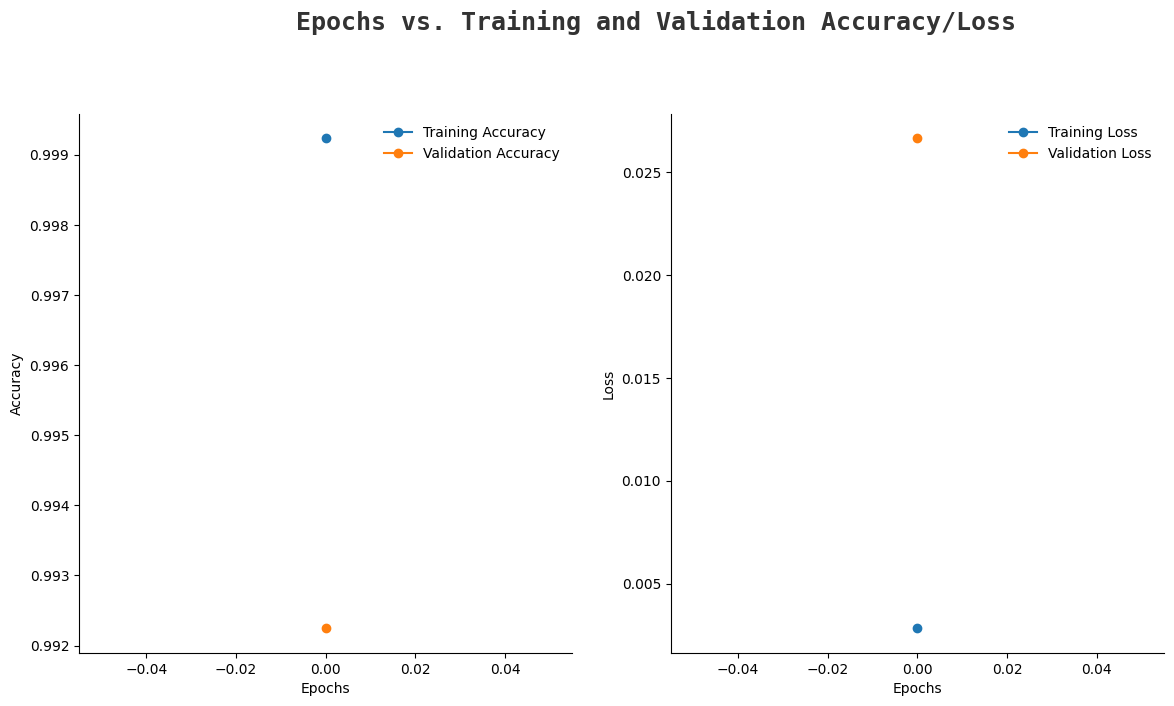

In [11]:
# Plot Training and Validation Accuracy and Loss
epochs = [i for i in range(1)]
fig, ax = plt.subplots(1, 2, figsize=(14, 7))
train_acc = np.mean(train_acc_per_fold)  # Average training accuracy
train_loss = np.mean(train_loss_per_fold)  # Average training loss
val_acc = np.mean(val_acc_per_fold)  # Average validation accuracy
val_loss = np.mean(val_loss_per_fold)  # Average validation loss

fig.text(s='Epochs vs. Training and Validation Accuracy/Loss', size=18, fontweight='bold',
         fontname='monospace', color='black', y=1, x=0.28, alpha=0.8)

sns.despine()
ax[0].plot(epochs, train_acc, marker='o', label='Training Accuracy')
ax[0].plot(epochs, val_acc, marker='o', label='Validation Accuracy')
ax[0].legend(frameon=False)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')

sns.despine()
ax[1].plot(epochs, train_loss, marker='o', label='Training Loss')
ax[1].plot(epochs, val_loss, marker='o', label='Validation Loss')
ax[1].legend(frameon=False)
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')

plt.show()

22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step
              precision    recall  f1-score   support

           0       0.99      0.97      0.98       170
           1       0.99      1.00      0.99       203
           2       0.96      0.98      0.97       174
           3       0.99      0.99      0.99       156

    accuracy                           0.98       703
   macro avg       0.98      0.98      0.98       703
weighted avg       0.98      0.98      0.98       703



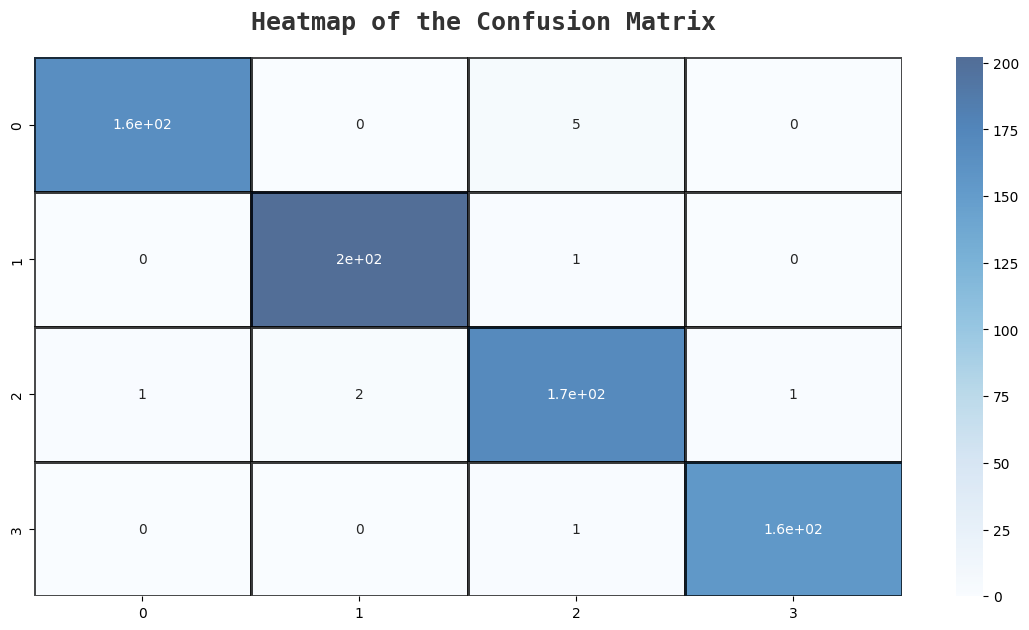

In [12]:
# Predictions and evaluation
pred = cnn_model.predict(X_test)
pred = np.argmax(pred, axis=1)
y_test_new = np.argmax(y_test, axis=1)
print(classification_report(y_test_new, pred))

# Confusion Matrix
fig, ax = plt.subplots(1, 1, figsize=(14, 7))
sns.heatmap(confusion_matrix(y_test_new, pred), ax=ax, annot=True, cmap='Blues', alpha=0.7,
            linewidths=2, linecolor='black')
fig.text(s='Heatmap of the Confusion Matrix', size=18, fontweight='bold',
         fontname='monospace', color='black', y=0.92, x=0.28, alpha=0.8)

plt.show()

In [13]:
# Accuracy 
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test_new, pred)
print(f"Test Accuracy: {accuracy * 100:.2f}%")
train_eval = cnn_model.evaluate(X_train, y_train)
print(f"Training Set Accuracy: {train_eval[1] * 100:.2f}%")
final_train_acc = history.history['accuracy'][-1]  # Get the last epoch's training accuracy
final_val_acc = history.history['val_accuracy'][-1]  # Get the last epoch's validation accuracy

print(f"Final Training Accuracy: {final_train_acc * 100:.2f}%")
print(f"Final Validation Accuracy: {final_val_acc * 100:.2f}%")

Test Accuracy: 98.44%
395/395 ━━━━━━━━━━━━━━━━━━━━ 21s 52ms/step - accuracy: 1.0000 - loss: 5.1677e-06
Training Set Accuracy: 100.00%
Final Training Accuracy: 99.98%
Final Validation Accuracy: 100.00%


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step


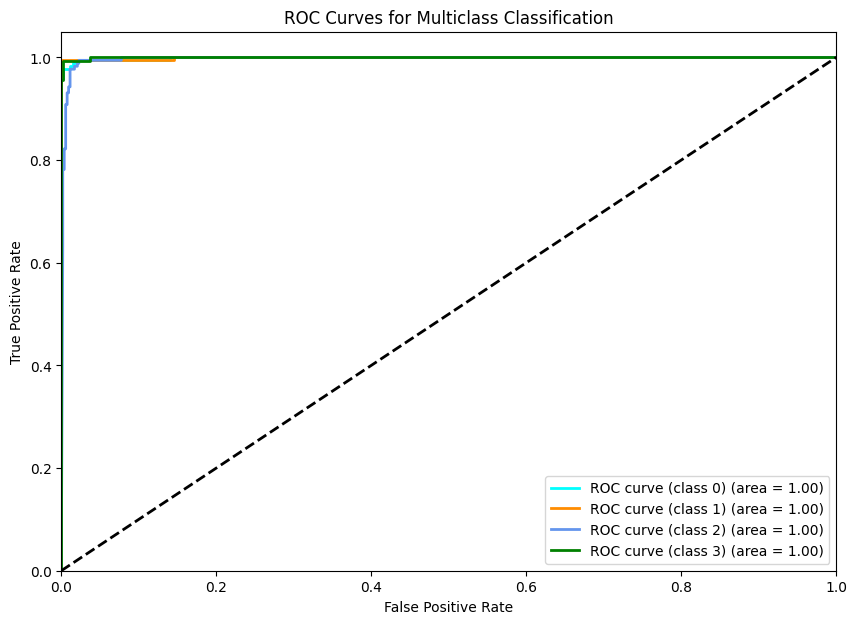

In [20]:
# ROC Curves
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from itertools import cycle

y_test_bin = label_binarize(y_test_new, classes=[0, 1, 2, 3])  # Adjust according to your classes
n_classes = y_test_bin.shape[1]

# Get predicted probabilities
y_pred_prob = cnn_model.predict(X_test)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves for each class
plt.figure(figsize=(10, 7))
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve (class {i}) (area = {roc_auc[i]:0.2f})')

# Plotting details
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Multiclass Classification')
plt.legend(loc="lower right")
plt.show()